# Faster R-CNN Model Evaluation

Comprehensive evaluation of Faster R-CNN model performance on parking lot detection task.

**Metrics Evaluated:**
- Object Detection: mAP@0.5, mAP@0.5:0.95, Precision, Recall
- Counting Accuracy: Exact Match Accuracy, Mean Absolute Error (MAE)
- Inference Speed: Frames Per Second (FPS)

## 1. Configuration

In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import json
from pathlib import Path
import time
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

RUN_DIR = Path('./runs/rcnn/')
DATA_DIR = Path('./data/')
MODEL_CHECKPOINT = RUN_DIR / 'latest.pt'
TEST_JSON = DATA_DIR / 'test.json'
TEST_IMG_DIR = DATA_DIR / 'test'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 2
BATCH_SIZE = 4
NUM_WORKERS = 0
SCORE_THRESHOLD = 0.5

if not MODEL_CHECKPOINT.exists():
    raise FileNotFoundError(f"Model checkpoint not found: {MODEL_CHECKPOINT}")
if not TEST_JSON.exists():
    raise FileNotFoundError(f"Test annotations not found: {TEST_JSON}")
if not TEST_IMG_DIR.exists():
    raise FileNotFoundError(f"Test images not found: {TEST_IMG_DIR}")

print(f"Device: {DEVICE}")
print(f"Model: {MODEL_CHECKPOINT}")
print(f"Data: {TEST_JSON}")
print(f"Config: batch={BATCH_SIZE}, score_thresh={SCORE_THRESHOLD}")

Device: cuda
Model: runs\rcnn\latest.pt
Data: data\test.json
Config: batch=4, score_thresh=0.5


## 2. Helper Functions

In [2]:
def get_model(num_classes, anchor_sizes=None):
    try:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
    except AttributeError:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    
    if anchor_sizes is not None:
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
        model.rpn.anchor_generator = anchor_generator
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

class COCODataset(torch.utils.data.Dataset):
    def __init__(self, json_file, img_dir, transforms=None):
        from pycocotools.coco import COCO
        self.img_dir = Path(img_dir)
        self.transforms = transforms
        self.coco = COCO(str(json_file))
        self.ids = list(sorted(self.coco.imgs.keys()))
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.img_dir / img_info['file_name']
        img = Image.open(img_path).convert('RGB')
        
        boxes, labels = [], []
        for ann in coco_anns:
            x, y, w, h = ann['bbox']
            if w <= 0 or h <= 0: continue
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64),
            "image_id": torch.tensor([img_id])
        }
        
        if self.transforms:
            img_tensor = self.transforms(img)
        
        return img_tensor, target, img
    
    def __len__(self):
        return len(self.ids)

def get_transform():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

## 3. Load Model and Data

In [3]:
args_file = RUN_DIR / 'args.json'
anchor_sizes = None
if args_file.exists():
    with open(args_file, 'r') as f:
        train_args = json.load(f)
    if train_args.get('anchor_sizes'):
        anchor_sizes = tuple(tuple([int(s)]) for s in train_args['anchor_sizes'].split(','))
        print(f"Using custom anchor sizes: {anchor_sizes}")

model = get_model(num_classes=NUM_CLASSES, anchor_sizes=anchor_sizes)
checkpoint = torch.load(MODEL_CHECKPOINT, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()
print("Model loaded successfully!")

test_dataset = COCODataset(TEST_JSON, TEST_IMG_DIR, transforms=get_transform())
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)

print(f"Test dataset: {len(test_dataset)} images")

Model loaded successfully!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Test dataset: 99 images


## 4. Object Detection Metrics (mAP)

In [ ]:
@torch.no_grad()
def evaluate_coco(model, data_loader, device, coco_gt):
    from pycocotools.cocoeval import COCOeval
    
    model.eval()
    coco_results = []
    
    for images, targets, _ in tqdm(data_loader, desc="Running detection"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for target, output in zip(targets, outputs):
            image_id = target['image_id'].item()
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            
            mask = scores > 0.05
            boxes, scores, labels = boxes[mask], scores[mask], labels[mask]
            
            for box, score, label in zip(boxes, scores, labels):
                if label == 0: continue
                x1, y1, x2, y2 = box
                w, h = x2 - x1, y2 - y1
                if w <= 0 or h <= 0: continue
                
                coco_results.append({
                    'image_id': int(image_id),
                    'category_id': 1,
                    'bbox': [float(x1), float(y1), float(w), float(h)],
                    'score': float(score)
                })
                
    if not coco_results:
        print("No predictions made")
        return None

    if 'info' not in coco_gt.dataset:
        coco_gt.dataset['info'] = []
        
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    # Extract metrics in same format as YOLOv9
    return {
        'map_50_95': coco_eval.stats[0],
        'map_50': coco_eval.stats[1],
        'precision': coco_eval.stats[0],  
        'recall': coco_eval.stats[8]      # AR@100
    }

bbox_metrics = evaluate_coco(model, test_loader, DEVICE, test_dataset.coco)

print("\nDetection Metrics:")
if bbox_metrics:
    for key, val in bbox_metrics.items():
        print(f"  {key}: {val:.4f}")

Running detection: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.11s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

## 5. Counting Metrics (Accuracy & MAE)

In [5]:
@torch.no_grad()
def calculate_counting_metrics(model, data_loader, device, score_threshold):
    model.eval()
    results = []
    
    for images, targets, _ in tqdm(data_loader, desc="Calculating counting metrics"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for i in range(len(images)):
            gt_count = len(targets[i]['labels'])
            pred_scores = outputs[i]['scores']
            pred_count = (pred_scores > score_threshold).sum().item()
            
            results.append({
                'gt_count': gt_count,
                'pred_count': pred_count,
                'difference': pred_count - gt_count,
                'abs_error': abs(pred_count - gt_count)
            })
    
    df = pd.DataFrame(results)
    
    correct_counts = (df['difference'] == 0).sum()
    total_images = len(df)
    exact_accuracy = (correct_counts / total_images) * 100
    mae = df['abs_error'].mean()
    
    return {'count_accuracy': exact_accuracy, 'count_mae': mae}, df

@torch.no_grad()
def calculate_fps(model, data_loader, device):
    model.eval()
    
    # Warm-up
    for i, (images, _, _) in enumerate(data_loader):
        if i >= 3: break
        images = [img.to(device) for img in images]
        _ = model(images)

    total_time, num_images = 0, 0
    for images, _, _ in tqdm(data_loader, desc="Measuring inference speed"):
        images = [img.to(device) for img in images]
        start_time = time.time()
        _ = model(images)
        total_time += (time.time() - start_time)
        num_images += len(images)
    
    return num_images / total_time if total_time > 0 else 0

counting_metrics, count_df = calculate_counting_metrics(model, test_loader, DEVICE, SCORE_THRESHOLD)
fps = calculate_fps(model, test_loader, DEVICE)

print("\nCounting Metrics:")
print(f"  Exact Accuracy: {counting_metrics['count_accuracy']:.2f}%")
print(f"  MAE: {counting_metrics['count_mae']:.4f}")
print(f"\nInference Speed: {fps:.2f} FPS")

Measuring inference speed: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Counting Metrics:
  Exact Accuracy: 25.25%
  MAE: 1.4747

Inference Speed: 7.88 FPS


## 6. Count Analysis Visualization

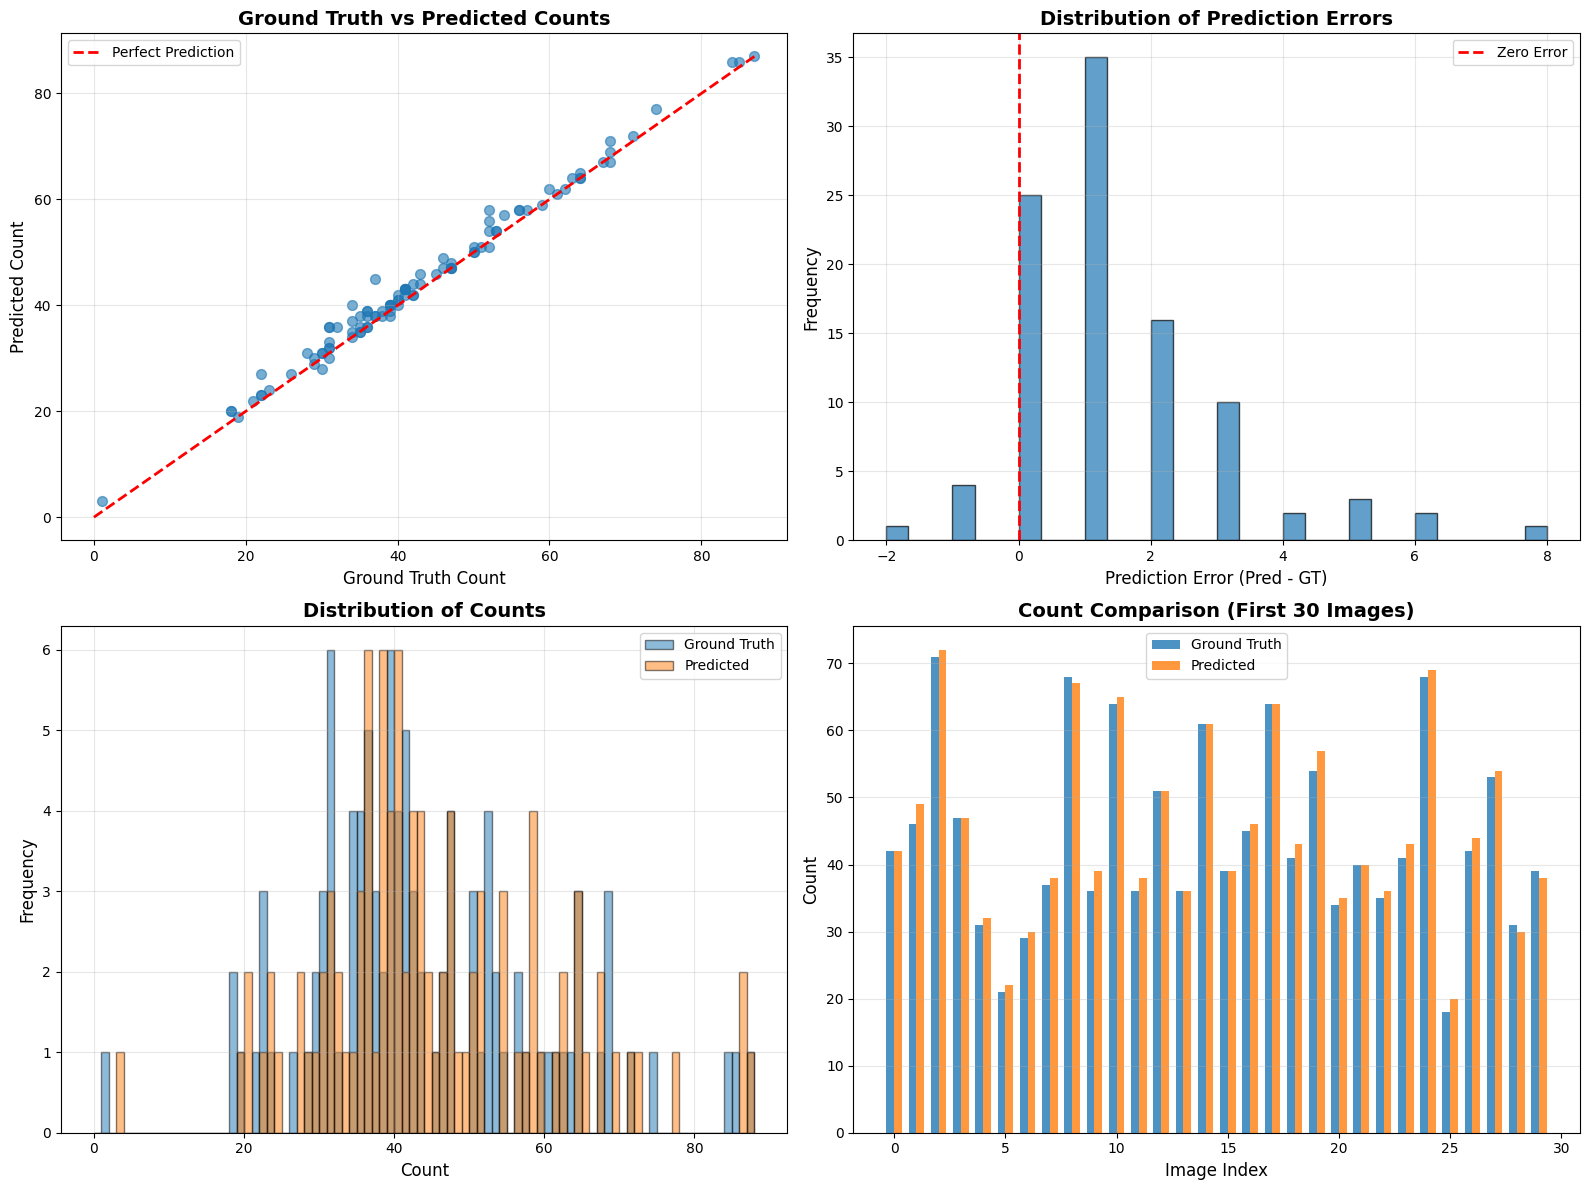


Count Analysis Statistics:
  Total images: 99
  Exact matches: 25 (25.25%)
  Mean GT count: 43.15
  Mean Pred count: 44.51
  GT count range: 1 - 87
  Pred count range: 3 - 87


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ground Truth vs Predicted scatter plot
ax1 = axes[0, 0]
ax1.scatter(count_df['gt_count'], count_df['pred_count'], alpha=0.6, s=50)
max_val = max(count_df['gt_count'].max(), count_df['pred_count'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Ground Truth Count', fontsize=12)
ax1.set_ylabel('Predicted Count', fontsize=12)
ax1.set_title('Ground Truth vs Predicted Counts', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error distribution histogram
ax2 = axes[0, 1]
ax2.hist(count_df['difference'], bins=30, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel('Prediction Error (Pred - GT)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Count distribution comparison
ax3 = axes[1, 0]
bins = np.arange(0, max(count_df['gt_count'].max(), count_df['pred_count'].max()) + 2, 1)
ax3.hist(count_df['gt_count'], bins=bins, alpha=0.5, label='Ground Truth', edgecolor='black')
ax3.hist(count_df['pred_count'], bins=bins, alpha=0.5, label='Predicted', edgecolor='black')
ax3.set_xlabel('Count', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Counts', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Sample-by-sample comparison (first 30 images)
ax4 = axes[1, 1]
n_samples = min(30, len(count_df))
x = np.arange(n_samples)
width = 0.35
ax4.bar(x - width/2, count_df['gt_count'].iloc[:n_samples], width, label='Ground Truth', alpha=0.8)
ax4.bar(x + width/2, count_df['pred_count'].iloc[:n_samples], width, label='Predicted', alpha=0.8)
ax4.set_xlabel('Image Index', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title(f'Count Comparison (First {n_samples} Images)', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nCount Analysis Statistics:")
print(f"  Total images: {len(count_df)}")
print(f"  Exact matches: {(count_df['difference'] == 0).sum()} ({(count_df['difference'] == 0).sum()/len(count_df)*100:.2f}%)")
print(f"  Mean GT count: {count_df['gt_count'].mean():.2f}")
print(f"  Mean Pred count: {count_df['pred_count'].mean():.2f}")
print(f"  GT count range: {count_df['gt_count'].min()} - {count_df['gt_count'].max()}")
print(f"  Pred count range: {count_df['pred_count'].min()} - {count_df['pred_count'].max()}")

## 7. Performance Summary

In [7]:
print("\n" + "="*50)
print("      Faster R-CNN Performance Summary")
print("="*50)

if bbox_metrics:
    print(f" mAP@0.5:0.95:        {bbox_metrics.get('map_50_95', 0):.4f}")
    print(f" mAP@0.5:             {bbox_metrics.get('map_50', 0):.4f}")
    print(f" Precision:           {bbox_metrics.get('precision', 0):.4f}")
    print(f" Recall:              {bbox_metrics.get('recall', 0):.4f}")
else:
    print(" Detection metrics unavailable")

print("-"*50)

if counting_metrics:
    print(f" Count Accuracy:      {counting_metrics.get('count_accuracy', 0):.2f}%")
    print(f" Count MAE:           {counting_metrics.get('count_mae', 0):.4f}")
else:
    print(" Counting metrics unavailable")
    
print("-"*50)

print(f" Inference Speed:     {fps:.2f} FPS")

print("="*50)


      Faster R-CNN Performance Summary
 mAP@0.5:0.95:        0.7696
 mAP@0.5:             0.9881
 Precision:           0.7696
 Recall:              0.8177
--------------------------------------------------
 Count Accuracy:      25.25%
 Count MAE:           1.4747
--------------------------------------------------
 Inference Speed:     7.88 FPS


## 8. Visualize Predictions

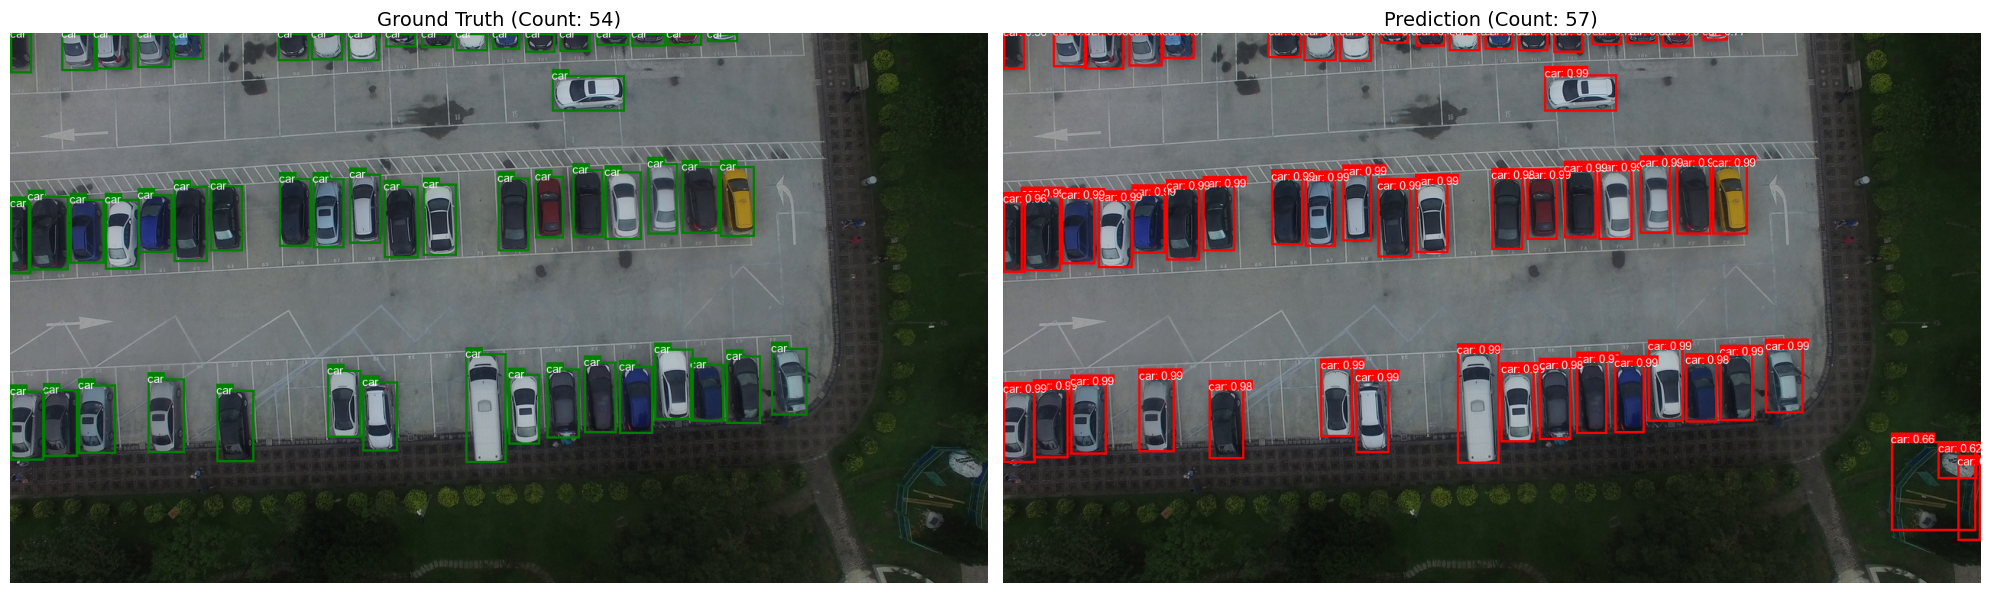

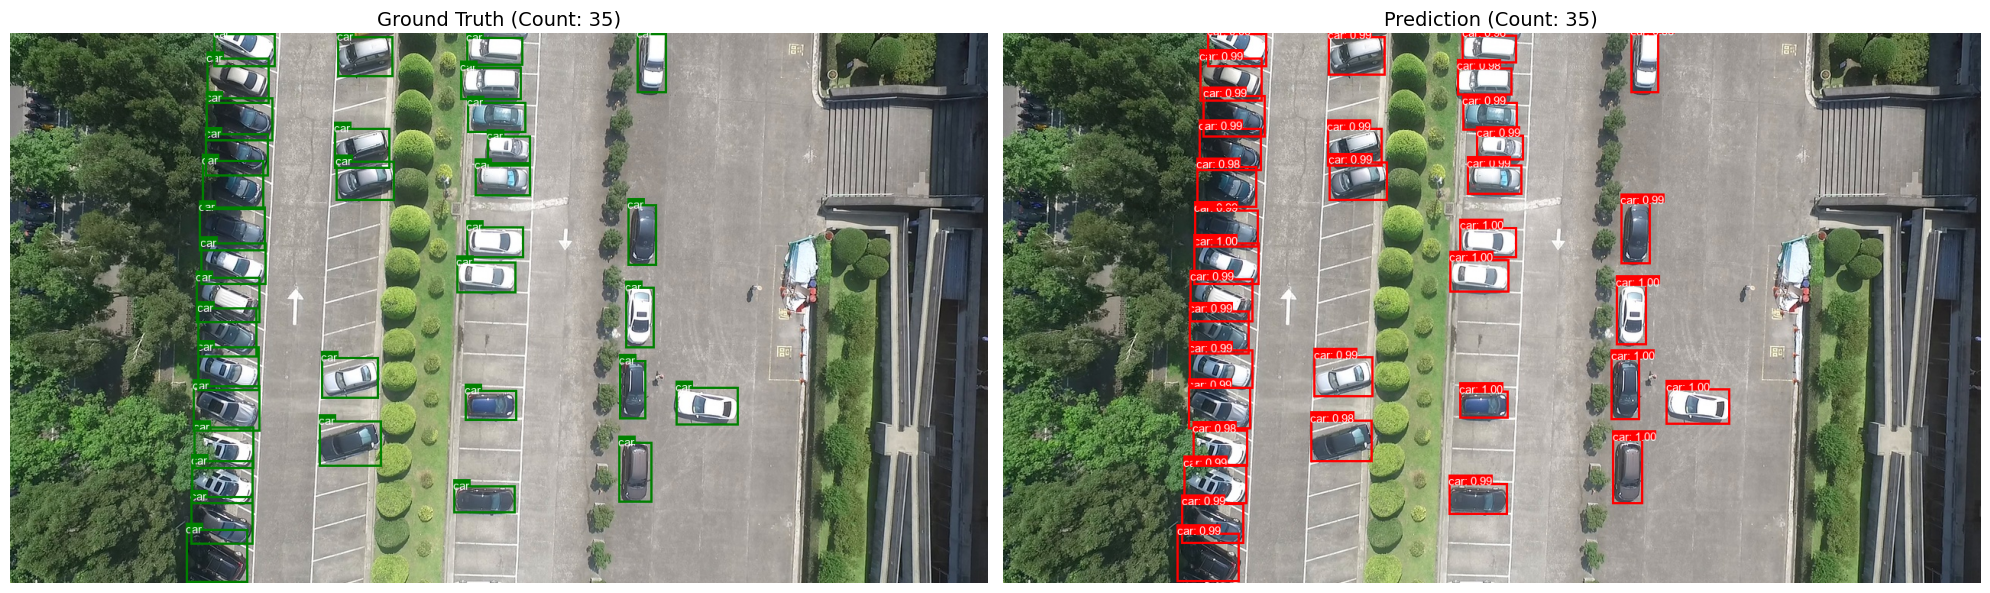

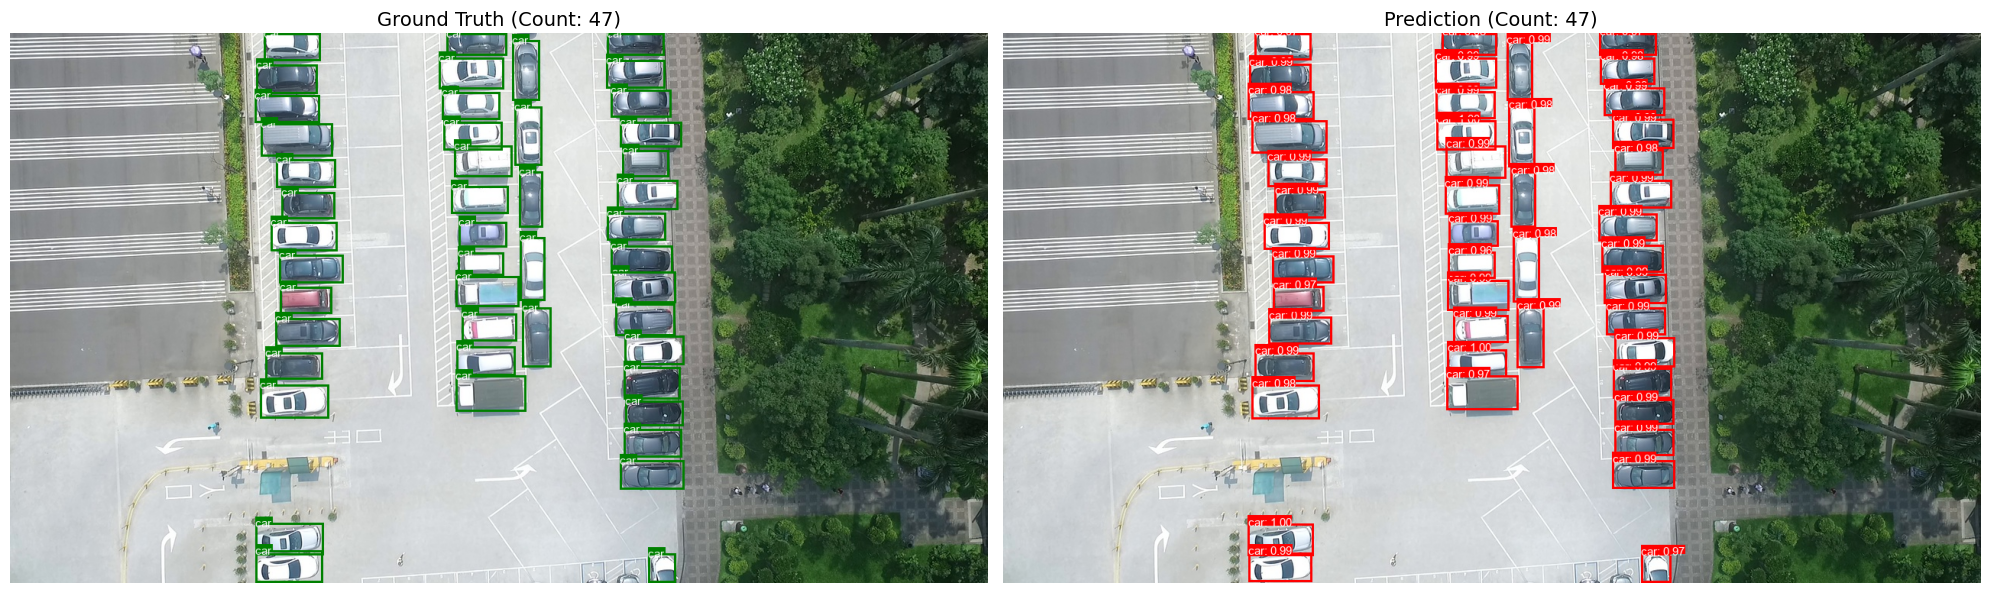

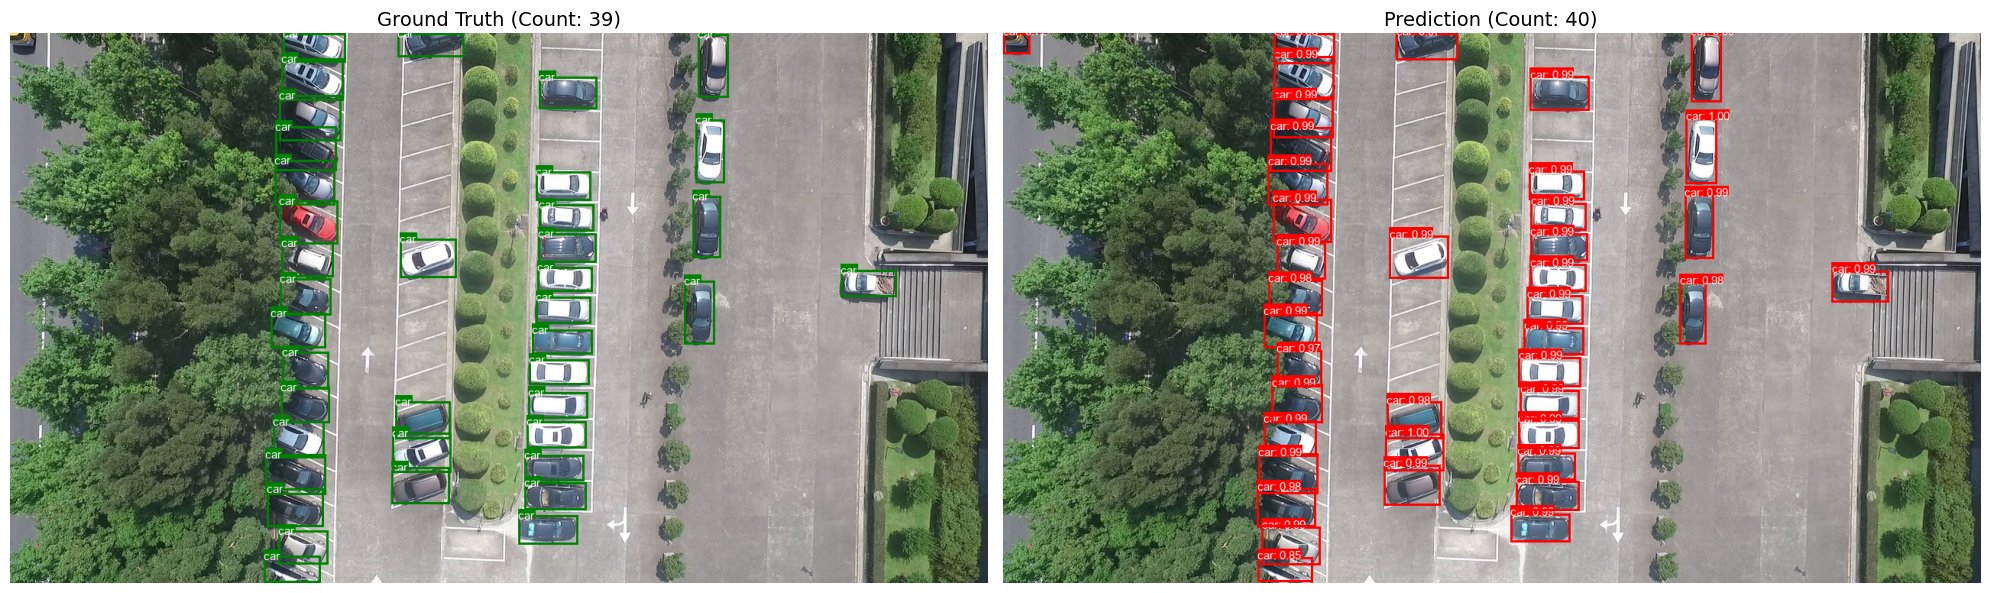

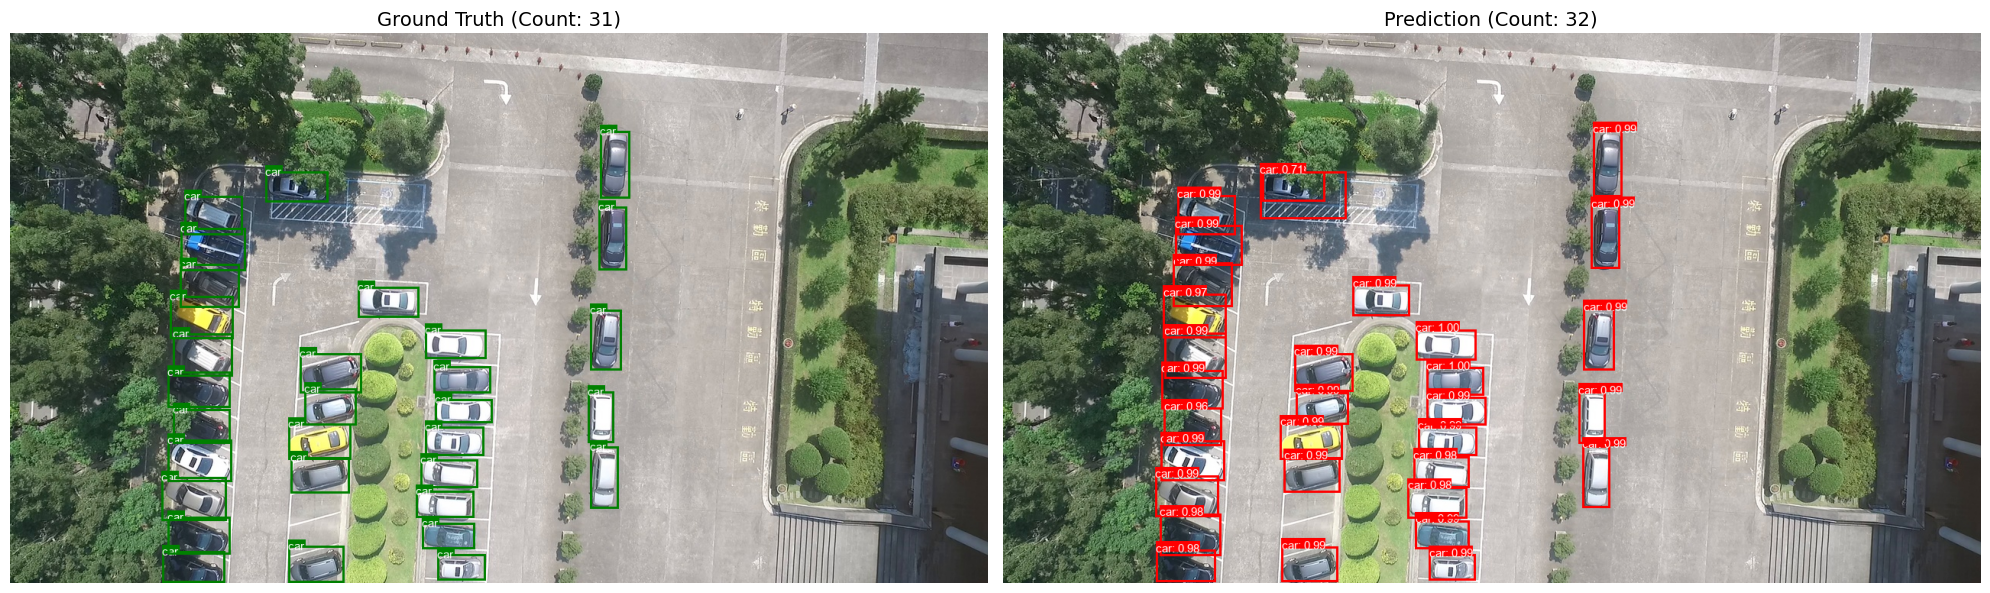

In [8]:
def draw_boxes(image, boxes, labels, color, text_prefix=''):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    for box, label in zip(boxes, labels):
        draw.rectangle(list(box), outline=color, width=3)
        text = f"{text_prefix}{label}"
        text_size = draw.textbbox((0,0), text, font=font)
        text_width = text_size[2] - text_size[0]
        text_height = text_size[3] - text_size[1]
        draw.rectangle([box[0], box[1] - text_height, box[0] + text_width, box[1]], fill=color)
        draw.text((box[0], box[1] - text_height), text, fill="white", font=font)

def visualize_predictions(model, dataset, num_samples=5, score_threshold=0.5):
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    for idx in indices:
        img_tensor, target, original_img = dataset[idx]
        
        # Ground Truth
        gt_img = original_img.copy()
        gt_boxes = target['boxes'].numpy()
        gt_count = len(gt_boxes)
        gt_labels = ['car'] * gt_count
        draw_boxes(gt_img, gt_boxes, gt_labels, color='green')
        
        # Prediction
        model.eval()
        with torch.no_grad():
            prediction = model([img_tensor.to(DEVICE)])[0]
        
        pred_img = original_img.copy()
        boxes = prediction['boxes'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()
        
        mask = scores > score_threshold
        boxes, scores = boxes[mask], scores[mask]
        pred_count = len(scores)
        pred_labels = [f"{s:.2f}" for s in scores]
        draw_boxes(pred_img, boxes, pred_labels, color='red', text_prefix='car: ')
        
        # Display
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.imshow(gt_img)
        ax1.set_title(f'Ground Truth (Count: {gt_count})', fontsize=14)
        ax1.axis('off')
        
        ax2.imshow(pred_img)
        ax2.set_title(f'Prediction (Count: {pred_count})', fontsize=14)
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

visualize_predictions(model, test_dataset, num_samples=5, score_threshold=SCORE_THRESHOLD)